In [1]:
import os
from dotenv import load_dotenv
import logging
import pandas as pd
import numpy as np
from pymongo import MongoClient
from sklearn.model_selection import train_test_split,StratifiedKFold,GridSearchCV
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.metrics import precision_recall_curve, auc, f1_score, accuracy_score, precision_score, recall_score, roc_auc_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
import mlflow
import mlflow.sklearn
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
import pickle
from xgboost.callback import EarlyStopping

In [2]:
# Logging

logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")

In [3]:
# Load env

load_dotenv()
MONGO_URI = os.environ.get("MONGO_URI")
DB_NAME = os.environ.get("DB_NAME")
MLFLOW_TRACKING_URI = os.environ.get("MLFLOW_TRACKING_URI")
MLFLOW_EXPERIMENT_NAME = os.environ.get("MLFLOW_EXPERIMENT_NAME")
RANDOM_STATE = int(os.environ.get("RANDOM_STATE"))
MLFLOW_LOCAL_URI = os.environ.get("MLFLOW_LOCAL_URI")

In [4]:
res=MLFLOW_LOCAL_URI.strip()
print (res)

file:///D:/fraud_detection/mlruns


In [5]:
if not MLFLOW_LOCAL_URI:
    raise ValueError("local path must be set in .env file")

In [6]:
if not MONGO_URI or not DB_NAME:
    raise ValueError("MONGO_URI and DB_NAME must be set in .env")

In [7]:
import os
import pathlib
import logging
import mlflow
import requests

def setup_mlflow(tracking_uri_env: str, local_uri_env: str, experiment_name: str):
    """
    Setup MLflow tracking URI and experiment.
    
    Args:
        tracking_uri_env (str): MLflow server URI (from env).
        local_uri_env (str): Local fallback URI (from env).
        experiment_name (str): Name of the MLflow experiment.
    
    Returns:
        str: The tracking URI being used.
    """
    def check_mlflow_server(uri: str) -> bool:
        """Check if MLflow server is reachable."""
        try:
            resp = requests.get(f"{uri.rstrip('/')}/api/2.0/mlflow/experiments/list", timeout=3)
            return resp.status_code == 200
        except Exception:
            return False

    tracking_uri_env = (tracking_uri_env or "").strip()
    local_uri_env = (local_uri_env or "").strip()

    # choose remote or local
    if check_mlflow_server(tracking_uri_env):
        tracking_uri = tracking_uri_env
        logging.info(f"✅ Connected to MLflow server at {tracking_uri_env}")
    else:
        tracking_uri = local_uri_env
        logging.warning(f"⚠️ Could not connect to {tracking_uri_env}. Falling back to {local_uri_env}")

    # ensure local dir exists
    if tracking_uri.startswith("file:///"):
        local_path = tracking_uri.replace("file:///", "")
        pathlib.Path(local_path).mkdir(parents=True, exist_ok=True)

    # configure mlflow
    mlflow.set_tracking_uri(tracking_uri)
    mlflow.set_experiment(experiment_name)

    logging.info(f"MLflow tracking URI = {tracking_uri}, experiment = {experiment_name}")
    return tracking_uri

In [8]:
# Utility: fetch collection as DataFrame
def fetch_collection_as_df(db, collection_name, sample_limit=None):
    """Return collection as pandas DataFrame. If sample_limit provided, limit docs."""
    cursor = db[collection_name].find()
    if sample_limit:
        cursor = cursor.limit(sample_limit)
    df = pd.DataFrame(list(cursor))
    # drop Mongo _id if present
    if "_id" in df.columns:
        df = df.drop(columns=["_id"])
    return df

In [9]:

# Connect to Mongo and load collections (the 10 CSVs)

with MongoClient(MONGO_URI) as client:
    db = client[DB_NAME]
    logging.info(f"Connected to MongoDB database: {DB_NAME}")

    # names from your docx / dataset
    account = fetch_collection_as_df(db, "account_activity")
    customer = fetch_collection_as_df(db, "customer_data")
    fraud = fetch_collection_as_df(db, "fraud_indicators")
    suspicion = fetch_collection_as_df(db, "suspicious_activity")
    merchant = fetch_collection_as_df(db, "merchant_data")
    tran_cat = fetch_collection_as_df(db, "transaction_category_labels")
    amount = fetch_collection_as_df(db, "amount_data")
    anomaly = fetch_collection_as_df(db, "anomaly_scores")
    tran_data = fetch_collection_as_df(db, "transaction_metadata")
    tran_rec = fetch_collection_as_df(db, "transaction_records")

logging.info("Loaded collections into pandas DataFrames")

2025-09-20 17:37:06,403 - INFO - Connected to MongoDB database: fraud_detection
2025-09-20 17:37:09,916 - INFO - Loaded collections into pandas DataFrames


In [10]:
# quick look at shapes
for name, df in [
    ("account", account), ("customer", customer), ("fraud", fraud), ("suspicion", suspicion),
    ("merchant", merchant), ("tran_cat", tran_cat), ("amount", amount), ("anomaly", anomaly),
    ("tran_data", tran_data), ("tran_rec", tran_rec)
]:
    logging.info(f"{name}: shape = {df.shape}")

2025-09-20 17:37:09,931 - INFO - account: shape = (1000, 3)
2025-09-20 17:37:09,932 - INFO - customer: shape = (1000, 4)
2025-09-20 17:37:09,933 - INFO - fraud: shape = (1000, 2)
2025-09-20 17:37:09,934 - INFO - suspicion: shape = (1000, 2)
2025-09-20 17:37:09,935 - INFO - merchant: shape = (1000, 3)
2025-09-20 17:37:09,936 - INFO - tran_cat: shape = (1000, 2)
2025-09-20 17:37:09,937 - INFO - amount: shape = (1000, 2)
2025-09-20 17:37:09,938 - INFO - anomaly: shape = (1000, 2)
2025-09-20 17:37:09,940 - INFO - tran_data: shape = (1000, 3)
2025-09-20 17:37:09,941 - INFO - tran_rec: shape = (1000, 3)


In [11]:
# Merge customer related
customer_data = pd.merge(customer, account, on="CustomerID", how="left")
customer_data = pd.merge(customer_data, suspicion, on="CustomerID", how="left")

# Merge transaction pieces
transaction_data1 = pd.merge(fraud, tran_cat, on="TransactionID", how="left")
transaction_data2 = pd.merge(amount, anomaly, on="TransactionID", how="left")
transaction_data3 = pd.merge(tran_data, tran_rec, on="TransactionID", how="left")

transaction_data = pd.merge(transaction_data1, transaction_data2, on="TransactionID", how="left")
transaction_data = pd.merge(transaction_data, transaction_data3, on="TransactionID", how="left")

# Final dataset
data = pd.merge(transaction_data, customer_data, on="CustomerID", how="left")
logging.info(f"Final merged data shape: {data.shape}")

2025-09-20 17:37:09,992 - INFO - Final merged data shape: (1000, 15)


In [12]:
#to export the data after merging
'''data.to_csv("final_data_after_merging.csv", index=False)
logging.info("Final data exported to final_data.csv")
'''


'data.to_csv("final_data_after_merging.csv", index=False)\nlogging.info("Final data exported to final_data.csv")\n'

In [13]:
data.head()

,TransactionID,FraudIndicator,Category,TransactionAmount,AnomalyScore,Timestamp,MerchantID,Amount,CustomerID,Name,Age,Address,AccountBalance,LastLogin,SuspiciousFlag
0,1,0,Other,79.413607,0.686699,2022-01-01 00:00:00,2701,55.530334,1952,Customer 1952,50,Address 1952,2869.689912,2024-08-09,0
1,2,0,Online,12.053087,0.081749,2022-01-01 01:00:00,2070,12.881180,1027,Customer 1027,46,Address 1027,9527.947107,2022-01-27,0
2,3,0,Travel,33.310357,0.023857,2022-01-01 02:00:00,2238,50.176322,1955,Customer 1955,34,Address 1955,9288.355525,2024-08-12,0
3,4,0,Travel,46.121117,0.876994,2022-01-01 03:00:00,2879,41.634001,1796,Customer 1796,33,Address 1796,5588.049942,2024-03-06,0
4,5,0,Other,54.051618,0.034059,2022-01-01 04:00:00,2966,78.122853,1946,Customer 1946,18,Address 1946,7324.785332,2024-08-03,0


In [14]:
display(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   TransactionID      1000 non-null   int64  
 1   FraudIndicator     1000 non-null   int64  
 2   Category           1000 non-null   object 
 3   TransactionAmount  1000 non-null   float64
 4   AnomalyScore       1000 non-null   float64
 5   Timestamp          1000 non-null   object 
 6   MerchantID         1000 non-null   int64  
 7   Amount             1000 non-null   float64
 8   CustomerID         1000 non-null   int64  
 9   Name               1000 non-null   object 
 10  Age                1000 non-null   int64  
 11  Address            1000 non-null   object 
 12  AccountBalance     1000 non-null   float64
 13  LastLogin          1000 non-null   object 
 14  SuspiciousFlag     1000 non-null   int64  
dtypes: float64(4), int64(6), object(5)
memory usage: 117.3+ KB


None

In [15]:
data.describe(include='all').T #,T to transpose

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
TransactionID,1000.0,NaN,NaN,NaN,500.5,288.819436,1.0,250.75,500.5,750.25,1000.0
FraudIndicator,1000.0,NaN,NaN,NaN,0.045,0.207408,0.0,0.0,0.0,0.0,1.0
Category,1000,5,Other,210,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TransactionAmount,1000.0,NaN,NaN,NaN,55.853826,26.093606,10.057864,33.875129,55.958313,77.589391,99.784323
AnomalyScore,1000.0,NaN,NaN,NaN,0.492282,0.288423,0.000234,0.251802,0.490242,0.741888,0.999047
Timestamp,1000,1000,2022-01-01 00:00:00,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MerchantID,1000.0,NaN,NaN,NaN,2504.701,288.414883,2001.0,2254.5,2500.5,2761.25,3000.0
Amount,1000.0,NaN,NaN,NaN,55.394871,25.070809,10.006933,34.502315,57.844325,75.858576,99.88741
CustomerID,1000.0,NaN,NaN,NaN,1496.626,289.229047,1001.0,1239.0,1501.0,1739.25,2000.0
Name,1000,636,Customer 1825,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN


2025-09-20 17:37:10,227 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
C:\Users\btirk\AppData\Local\Temp\ipykernel_8152\338882579.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x="FraudIndicator", data=data, palette="Set2")
2025-09-20 17:37:10,244 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


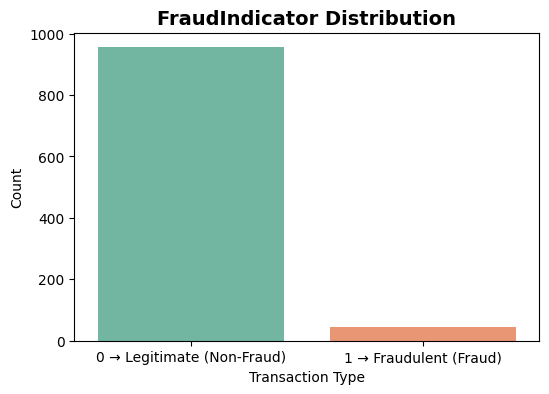

In [16]:
# Target distribution with meaningful ticks
plt.figure(figsize=(6,4))
ax = sns.countplot(x="FraudIndicator", data=data, palette="Set2")

# Set custom tick labels
ax.set_xticks([0, 1])
ax.set_xticklabels(["0 → Legitimate (Non-Fraud)", "1 → Fraudulent (Fraud)"])

plt.title("FraudIndicator Distribution", fontsize=14, fontweight="bold")
plt.xlabel("Transaction Type")
plt.ylabel("Count")
plt.show()


In [17]:
# numeric / categorical split
numerical_features = data.select_dtypes(include=["number"]).columns.tolist()
categorical_features = data.select_dtypes(include=["object"]).columns.tolist()
print("Numerical features:", numerical_features)
print("Categorical features:", categorical_features)

Numerical features: ['TransactionID', 'FraudIndicator', 'TransactionAmount', 'AnomalyScore', 'MerchantID', 'Amount', 'CustomerID', 'Age', 'AccountBalance', 'SuspiciousFlag']
Categorical features: ['Category', 'Timestamp', 'Name', 'Address', 'LastLogin']


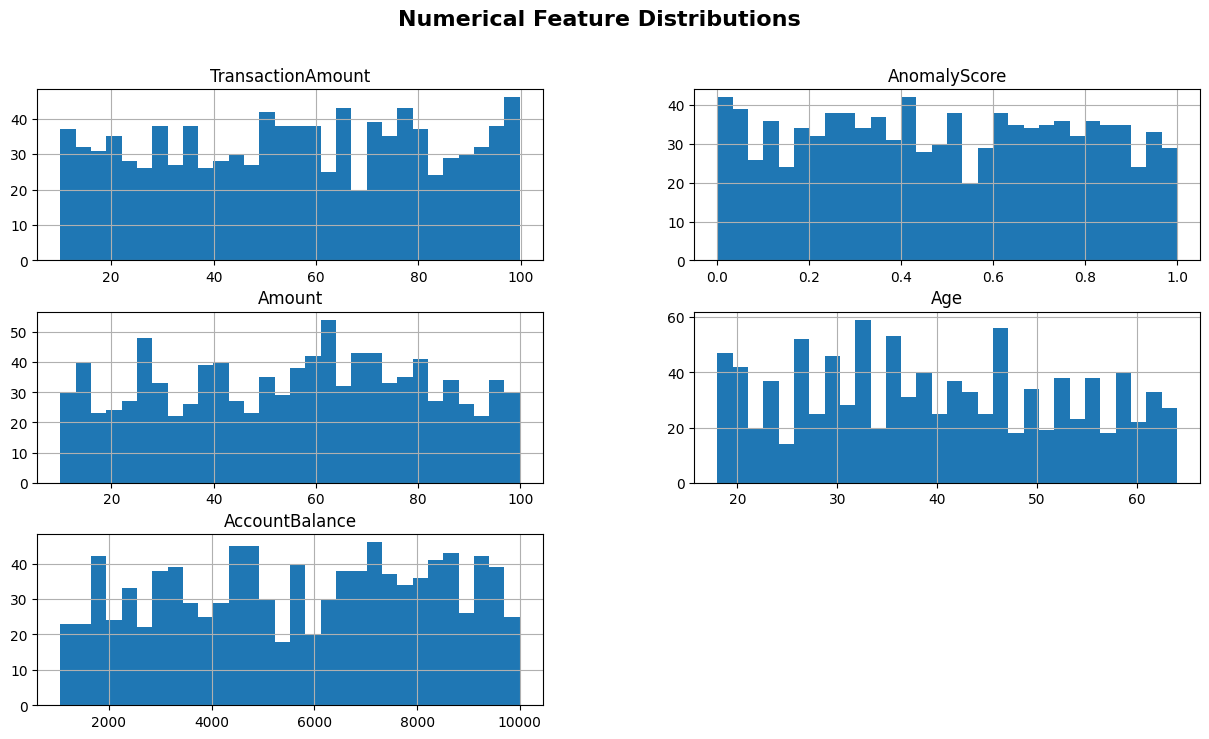

In [18]:
# Histograms for numerical features
num_cols = ['TransactionAmount', 'AnomalyScore', 'Amount', 'Age', 'AccountBalance']
data[num_cols].hist(bins=30, figsize=(15,8))
plt.suptitle("Numerical Feature Distributions", fontsize=16, fontweight="bold")
plt.show()

2025-09-20 17:37:11,314 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
C:\Users\btirk\AppData\Local\Temp\ipykernel_8152\3957645407.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="FraudIndicator", y=col, data=data, palette="Set2")
2025-09-20 17:37:11,327 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-09-20 17:37:11,377 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
C:\Users\btirk

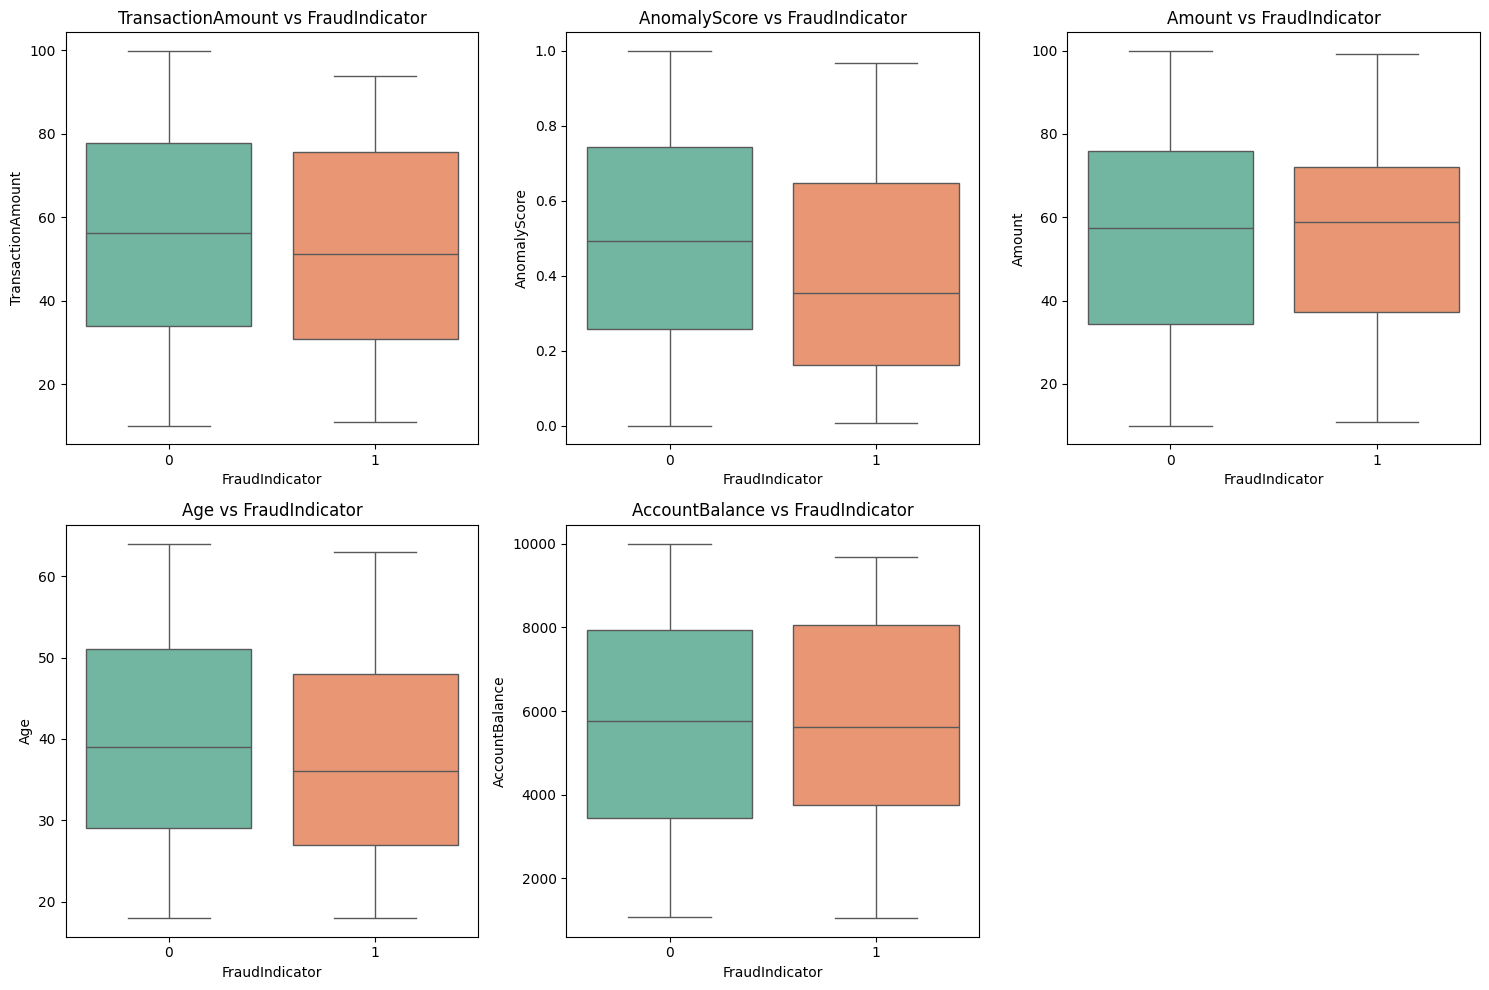

In [19]:
# Boxplots for fraud vs non-fraud
plt.figure(figsize=(15,10))
for i, col in enumerate(num_cols, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(x="FraudIndicator", y=col, data=data, palette="Set2")
    plt.title(f"{col} vs FraudIndicator")
plt.tight_layout()
plt.show()

C:\Users\btirk\AppData\Local\Temp\ipykernel_8152\4168932719.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="Category", data=data, order=data["Category"].value_counts().index, palette="Set2")


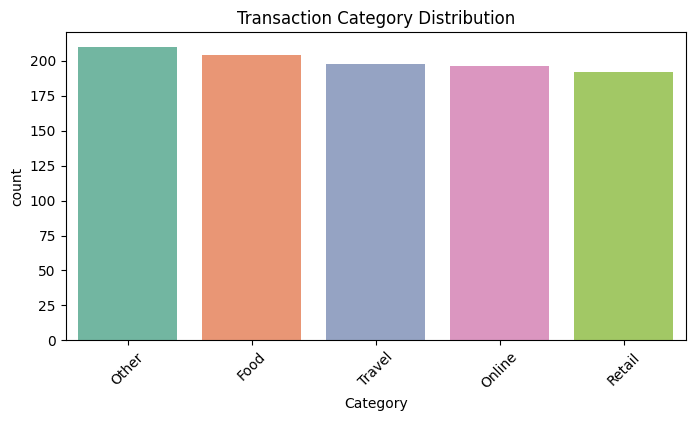

In [20]:
# Category distribution
plt.figure(figsize=(8,4))
sns.countplot(x="Category", data=data, order=data["Category"].value_counts().index, palette="Set2")
plt.title("Transaction Category Distribution")
plt.xticks(rotation=45)
plt.show()

C:\Users\btirk\AppData\Local\Temp\ipykernel_8152\2454363857.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=fraud_by_cat.index, y=fraud_by_cat.values, palette="coolwarm")


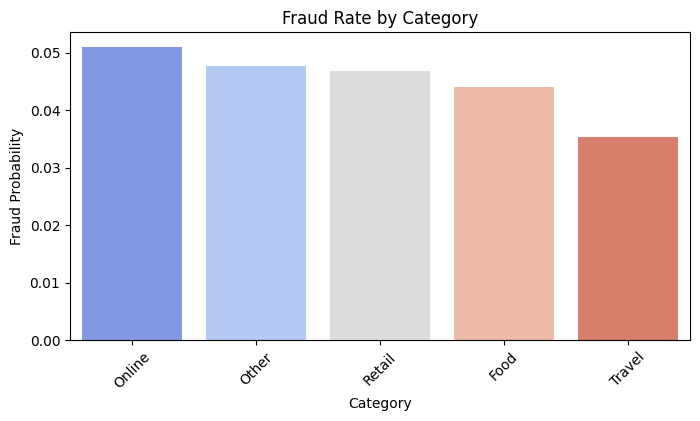

In [21]:
# Fraud rate by Category
fraud_by_cat = data.groupby("Category")["FraudIndicator"].mean().sort_values(ascending=False)
plt.figure(figsize=(8,4))
sns.barplot(x=fraud_by_cat.index, y=fraud_by_cat.values, palette="coolwarm")
plt.title("Fraud Rate by Category")
plt.ylabel("Fraud Probability")
plt.xticks(rotation=45)
plt.show()

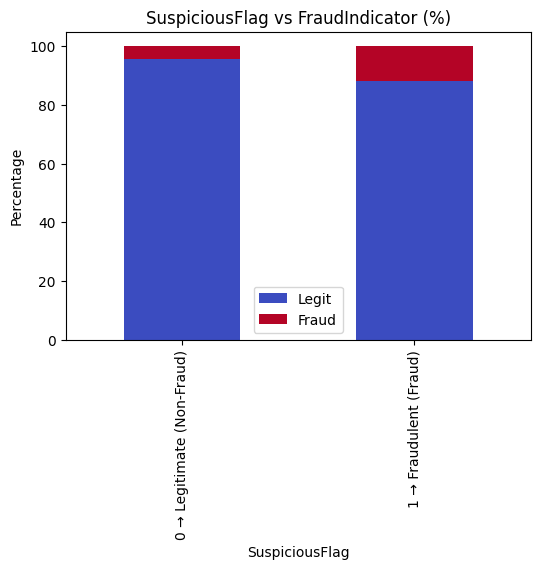

In [22]:
# SuspiciousFlag vs FraudIndicator
ct = pd.crosstab(data["SuspiciousFlag"], data["FraudIndicator"], normalize="index") * 100

# Plot and capture axis
ax = ct.plot(kind="bar", stacked=True, figsize=(6,4), colormap="coolwarm")

# Set custom tick labels
ax.set_xticks([0, 1])
ax.set_xticklabels(["0 → Legitimate (Non-Fraud)", "1 → Fraudulent (Fraud)"])

plt.title("SuspiciousFlag vs FraudIndicator (%)")
plt.ylabel("Percentage")
plt.legend(["Legit", "Fraud"])
plt.show()

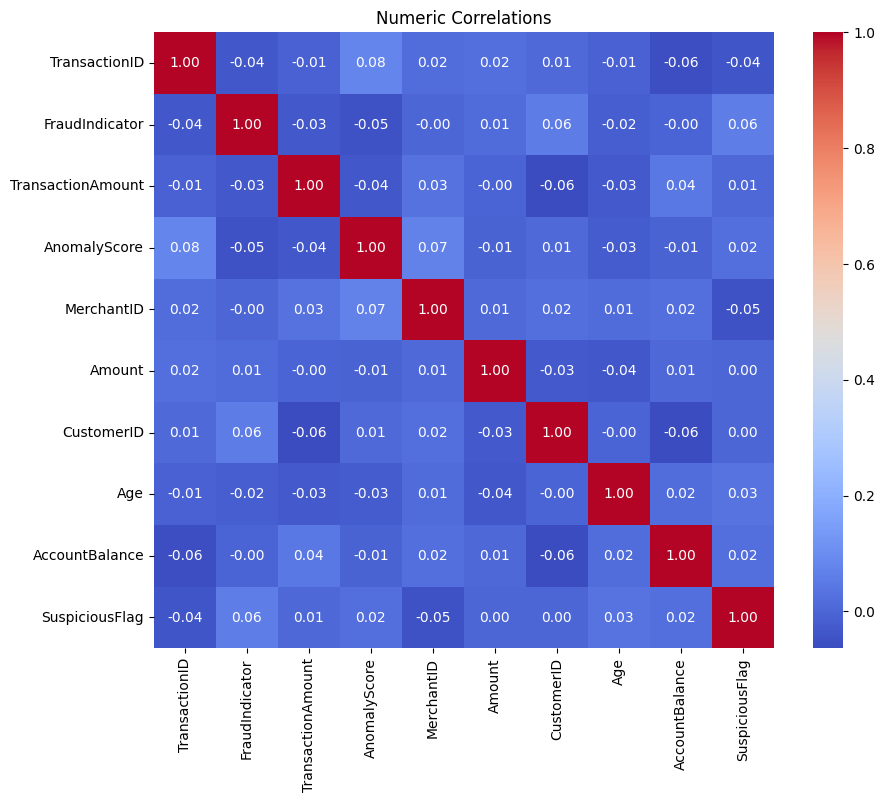

In [23]:
# Correlation heatmap for numeric
plt.figure(figsize=(10,8))
sns.heatmap(data[numerical_features].corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Numeric Correlations")
plt.show()

In [24]:
# Drop identifiers and verbose text (keep only columns helpful for modeling)
drop_cols = ["TransactionID", "MerchantID", "CustomerID", "Name", "Address", "LastLogin"]  # last login used later after converting to datetime
for c in drop_cols:
    if c not in data.columns:
        logging.warning(f"{c} not in data; skipping drop.")

In [25]:
# Keep needed columns, create copy
df = data.copy()

In [26]:
# Convert timestamps
df["Timestamp1"] = pd.to_datetime(df["Timestamp"], errors="coerce")
df["LastLogin_dt"] = pd.to_datetime(df["LastLogin"], errors="coerce")

In [27]:
# Hour and gap features
df["Hour"] = df["Timestamp1"].dt.hour.fillna(-1).astype(int)
df["gap"] = (df["Timestamp1"] - df["LastLogin_dt"]).dt.days.abs()
df["gap"] = df["gap"].fillna(df["gap"].median())

2025-09-20 17:37:13,132 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-09-20 17:37:13,142 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


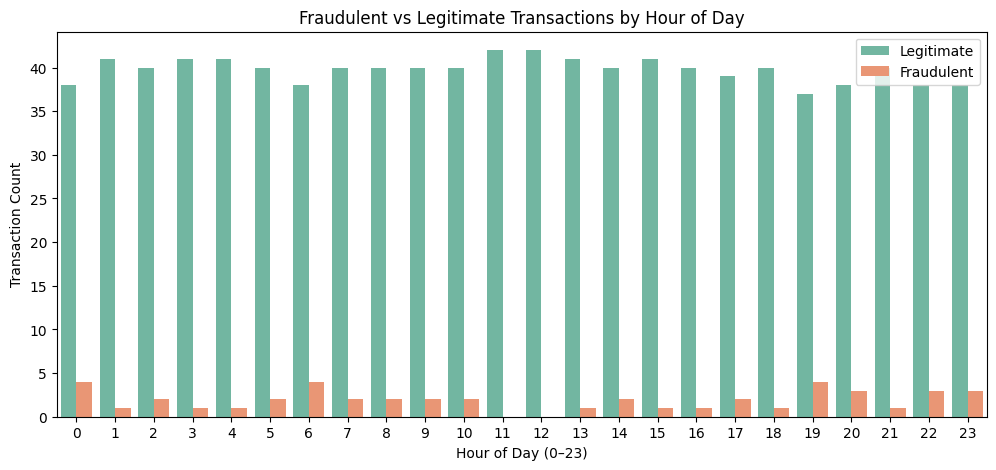

In [28]:
# Fraud vs Legit transactions by hour
plt.figure(figsize=(12,5))
sns.countplot(x="Hour", hue="FraudIndicator", data=df, palette="Set2")
plt.title("Fraudulent vs Legitimate Transactions by Hour of Day")
plt.xlabel("Hour of Day (0–23)")
plt.ylabel("Transaction Count")
plt.legend(["Legitimate", "Fraudulent"])
plt.show()

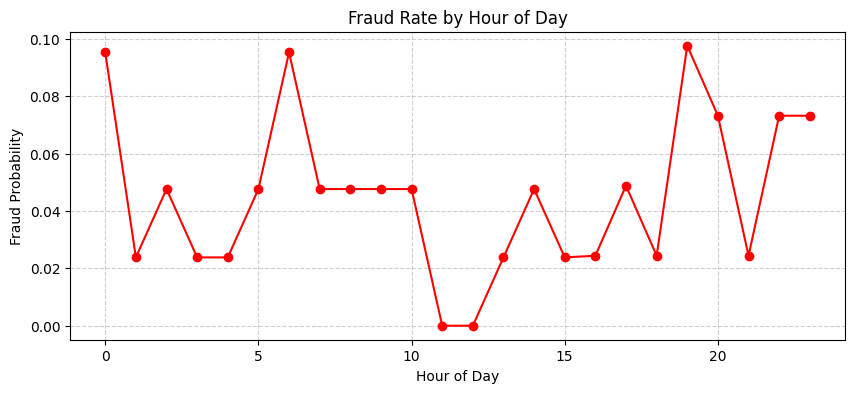

In [29]:
# Fraud rate per hour
fraud_by_hour = df.groupby("Hour")["FraudIndicator"].mean()
plt.figure(figsize=(10,4))
fraud_by_hour.plot(marker="o", color="red")
plt.title("Fraud Rate by Hour of Day")
plt.ylabel("Fraud Probability")
plt.xlabel("Hour of Day")
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

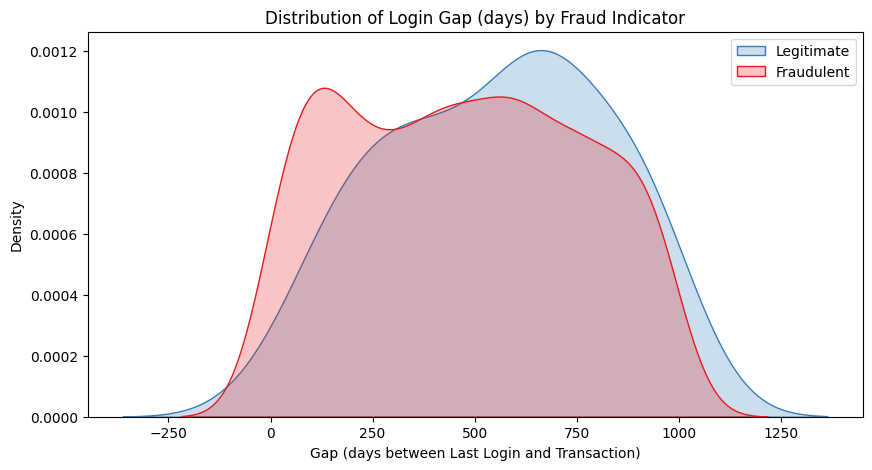

In [30]:
# Distribution of gap for fraud vs legit
plt.figure(figsize=(10,5))
sns.kdeplot(x="gap", hue="FraudIndicator", data=df, fill=True, common_norm=False, palette="Set1")
plt.title("Distribution of Login Gap (days) by Fraud Indicator")
plt.xlabel("Gap (days between Last Login and Transaction)")
plt.ylabel("Density")
plt.legend(["Legitimate", "Fraudulent"])
plt.show()

2025-09-20 17:37:13,766 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
C:\Users\btirk\AppData\Local\Temp\ipykernel_8152\2665772250.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="FraudIndicator", y="gap", data=df, palette="Set2")
2025-09-20 17:37:13,776 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


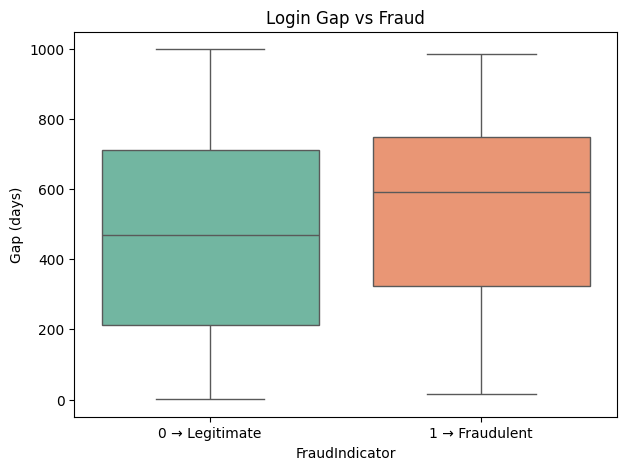

,count,mean,std,min,25%,50%,75%,max
FraudIndicator,,,,,,,,
0,955.0,472.335079,288.840621,1.0,211.5,470.0,711.5,998.0
1,45.0,551.111111,270.494095,17.0,324.0,591.0,749.0,985.0


In [31]:
# Boxplot comparison
plt.figure(figsize=(7,5))
sns.boxplot(x="FraudIndicator", y="gap", data=df, palette="Set2")
plt.title("Login Gap vs Fraud")
plt.xticks([0,1], ["0 → Legitimate", "1 → Fraudulent"])
plt.ylabel("Gap (days)")
plt.show()

# Summary stats
gap_summary = df.groupby("FraudIndicator")["gap"].describe()
display(gap_summary)

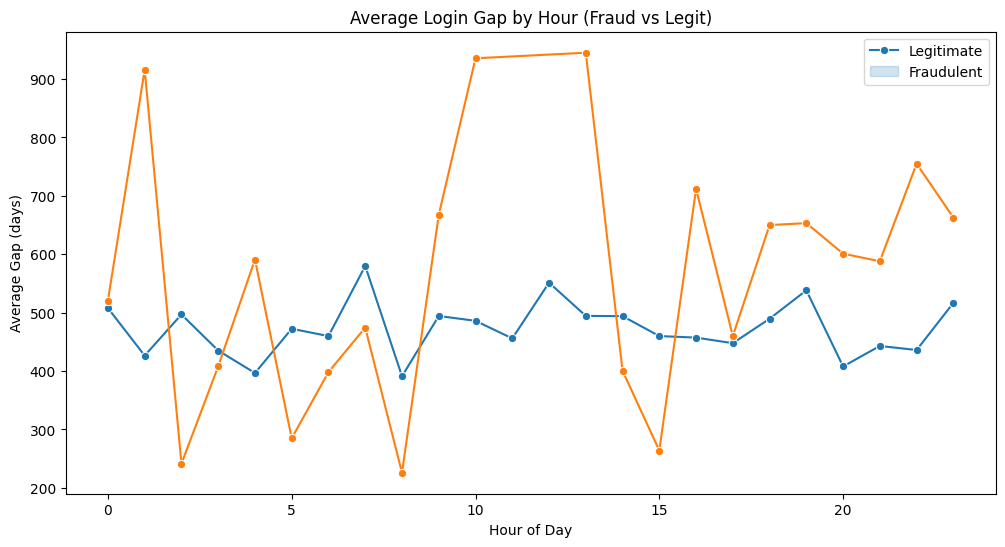

In [32]:
# Average gap by hour and fraud
avg_gap = df.groupby(["Hour","FraudIndicator"])["gap"].mean().reset_index()

plt.figure(figsize=(12,6))
sns.lineplot(x="Hour", y="gap", hue="FraudIndicator", data=avg_gap, marker="o")
plt.title("Average Login Gap by Hour (Fraud vs Legit)")
plt.xlabel("Hour of Day")
plt.ylabel("Average Gap (days)")
plt.legend(["Legitimate", "Fraudulent"])
plt.show()


Insight

Fraud Timing: More fraud occurs at night (0–1 hrs) and evening (18–23 hrs).

Login Gap: Fraudulent accounts tend to have longer and more irregular inactivity gaps than legitimate users.

Detection Strategy: Monitoring login gaps and transaction timing could improve fraud detection. Accounts transacting after unusually long inactivity, especially late-night, should be flagged for higher scrutiny.

In [33]:
# Simplify target and feature set
model_df = df.drop(columns=[c for c in drop_cols if c in df.columns] + ["Timestamp", "Timestamp1", "LastLogin", "LastLogin_dt"])

In [34]:
# Fill missing numericals with median
for col in model_df.select_dtypes(include=["number"]).columns:
    model_df[col] = model_df[col].fillna(model_df[col].median())

In [35]:
# Encode Category using LabelEncoder 
le = LabelEncoder()
if "Category" in model_df.columns:
    model_df["Category"] = model_df["Category"].fillna("Unknown")
    model_df["Category_enc"] = le.fit_transform(model_df["Category"])
    model_df = model_df.drop(columns=["Category"])
else:
    logging.warning("Category column not found")

display(model_df.head())

,FraudIndicator,TransactionAmount,AnomalyScore,Amount,Age,AccountBalance,SuspiciousFlag,Hour,gap,Category_enc
0,0,79.413607,0.686699,55.530334,50,2869.689912,0,0,951,2
1,0,12.053087,0.081749,12.881180,46,9527.947107,0,1,26,1
2,0,33.310357,0.023857,50.176322,34,9288.355525,0,2,954,4
3,0,46.121117,0.876994,41.634001,33,5588.049942,0,3,795,4
4,0,54.051618,0.034059,78.122853,18,7324.785332,0,4,945,2


In [36]:

# Prepare X, y
if "FraudIndicator" not in model_df.columns:
    raise ValueError("FraudIndicator (target) not present in data")

X = model_df.drop(columns=["FraudIndicator"])
y = model_df["FraudIndicator"]

In [37]:
# Final numeric-only feature matrix (we already encoded Category->Category_enc)
X = X.select_dtypes(include=[np.number]).copy()
logging.info(f"Final X shape: {X.shape}, y shape: {y.shape}")

2025-09-20 17:37:14,150 - INFO - Final X shape: (1000, 9), y shape: (1000,)


In [38]:
X.head()

,TransactionAmount,AnomalyScore,Amount,Age,AccountBalance,SuspiciousFlag,Hour,gap,Category_enc
0,79.413607,0.686699,55.530334,50,2869.689912,0,0,951,2
1,12.053087,0.081749,12.881180,46,9527.947107,0,1,26,1
2,33.310357,0.023857,50.176322,34,9288.355525,0,2,954,4
3,46.121117,0.876994,41.634001,33,5588.049942,0,3,795,4
4,54.051618,0.034059,78.122853,18,7324.785332,0,4,945,2


In [39]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   TransactionAmount  1000 non-null   float64
 1   AnomalyScore       1000 non-null   float64
 2   Amount             1000 non-null   float64
 3   Age                1000 non-null   int64  
 4   AccountBalance     1000 non-null   float64
 5   SuspiciousFlag     1000 non-null   int64  
 6   Hour               1000 non-null   int32  
 7   gap                1000 non-null   int64  
 8   Category_enc       1000 non-null   int32  
dtypes: float64(4), int32(2), int64(3)
memory usage: 62.6 KB


In [40]:
X.columns

Index(['TransactionAmount', 'AnomalyScore', 'Amount', 'Age', 'AccountBalance',
       'SuspiciousFlag', 'Hour', 'gap', 'Category_enc'],
      dtype='object')

In [41]:
y.sample(5)

72     0
255    0
273    0
76     0
973    0
Name: FraudIndicator, dtype: int64

In [42]:
y.value_counts()

FraudIndicator
0    955
1     45
Name: count, dtype: int64

In [43]:
# Train-test split (doing this BEFORE SMOTE)
# Stratify to maintain class balance to split traget column equally in train, test and validation sets


# Train-Test-Validation Split

X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=RANDOM_STATE, stratify=y_temp
) 
# 0.25 * 0.8 = 0.2 → 60/20/20 split

logging.info(f"Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")


2025-09-20 17:37:14,274 - INFO - Train: (600, 9), Val: (200, 9), Test: (200, 9)


In [44]:
#checking shapes
print("X_train:", X_train.shape, "y_train:", y_train.shape)
print("X_val:", X_val.shape, "y_val:", y_val.shape)
print("X_test:", X_test.shape, "y_test:", y_test.shape)

X_train: (600, 9) y_train: (600,)
X_val: (200, 9) y_val: (200,)
X_test: (200, 9) y_test: (200,)


In [45]:
# Scaling
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [46]:
#checking shapes
print("X_train:", X_train_scaled.shape, "y_train:", y_train.shape)
print("X_val:", X_val_scaled.shape , "y_val:", y_val.shape)
print("X_test:", X_test_scaled.shape, "y_test:", y_test.shape)

X_train: (600, 9) y_train: (600,)
X_val: (200, 9) y_val: (200,)
X_test: (200, 9) y_test: (200,)


In [47]:
# SMOTE on TRAIN only
# --------------------------
# ✅ Apply SMOTE only on TRAIN
smote = SMOTE(random_state=RANDOM_STATE)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)


logging.info(f"After SMOTE -> X_train_smote: {X_train_smote.shape}, y_train_smote distribution:\n{pd.Series(y_train_smote).value_counts()}")


2025-09-20 17:37:14,355 - INFO - After SMOTE -> X_train_smote: (1146, 9), y_train_smote distribution:
FraudIndicator
1    573
0    573
Name: count, dtype: int64


In [48]:
models = {
    "LogisticRegression": LogisticRegression(random_state=RANDOM_STATE, max_iter=1000, class_weight='balanced'),
    "DecisionTreeClassifier": DecisionTreeClassifier(random_state=RANDOM_STATE, class_weight='balanced'),
    "RandomForestClassifier": RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1, class_weight='balanced'),
    "GradientBoostingClassifier": GradientBoostingClassifier(random_state=RANDOM_STATE),
    "XGBoostClassifier": xgb.XGBClassifier(
        random_state=RANDOM_STATE,
        use_label_encoder=False,
        eval_metric='logloss',
        scale_pos_weight=(y_train==0).sum()/(y_train==1).sum()
    )
}

param_grids = {
    "LogisticRegression": {
        "C": [0.01, 0.1, 1, 10],
        "solver": ["liblinear", "saga"]
    },
    "DecisionTreeClassifier": {
        "max_depth": [3, 5, 10, None],
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [1, 2, 4]
    },
    "RandomForestClassifier": {
        "n_estimators": [50, 100, 200],
        "max_depth": [5, 10, None],
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [1, 2, 4]
    },
    "GradientBoostingClassifier": {
        "n_estimators": [50, 100, 200],
        "learning_rate": [0.01, 0.1, 0.2],
        "max_depth": [3, 5, 7]
    },
    "XGBoostClassifier": {
        "n_estimators": [50, 100, 200],
        "learning_rate": [0.01, 0.1, 0.2],
        "max_depth": [3, 5, 7]
    }
}


In [49]:
import os
import mlflow
from dotenv import load_dotenv
import requests

# Load environment variables
load_dotenv()

MLFLOW_TRACKING_URI = os.getenv("MLFLOW_TRACKING_URI")
MLFLOW_EXPERIMENT_NAME = os.getenv("MLFLOW_EXPERIMENT_NAME")
MLFLOW_LOCAL_URI = os.getenv("MLFLOW_LOCAL_URI")

def is_mlflow_running(uri):
    try:
        # Quick health check by hitting mlflow UI API
        response = requests.get(f"{uri}/api/2.0/mlflow/experiments/list", timeout=3)
        return response.status_code == 200
    except Exception:
        return False

def evaluate_and_log_threshold(model, model_name, params=None):
    # --------------------------
    # Step 1: Set MLflow backend
    # --------------------------
    if is_mlflow_running(MLFLOW_TRACKING_URI):
        mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)
        mlflow.set_experiment(MLFLOW_EXPERIMENT_NAME)
        logging.info("✅ Connected to MLflow server")
    else:
        mlflow.set_tracking_uri(MLFLOW_LOCAL_URI)
        mlflow.set_experiment(MLFLOW_EXPERIMENT_NAME)
        logging.info("⚡ Using local MLflow tracking")

    # --------------------------
    # Step 2: Start MLflow run
    # --------------------------
    with mlflow.start_run(run_name=model_name):
        mlflow.log_param("model", model_name)
        if params:
            for k, v in params.items():
                mlflow.log_param(k, v)

        # --------------------------
        # Step 3: Train model
        # --------------------------
        model.fit(X_train_smote, y_train_smote)

        # --------------------------
        # Step 4: Threshold tuning (Validation set)
        # --------------------------
        y_val_proba = model.predict_proba(X_val_scaled)[:, 1] if hasattr(model, "predict_proba") else model.decision_function(X_val_scaled)
        precision, recall, thresholds = precision_recall_curve(y_val, y_val_proba)
        f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
        best_idx = np.argmax(f1_scores)
        best_threshold = thresholds[best_idx]

        # --------------------------
        # Step 5: Evaluate on Test set
        # --------------------------
        y_test_proba = model.predict_proba(X_test_scaled)[:, 1] if hasattr(model, "predict_proba") else model.decision_function(X_test_scaled)
        y_test_pred = (y_test_proba >= best_threshold).astype(int)

        acc = accuracy_score(y_test, y_test_pred)
        prec = precision_score(y_test, y_test_pred, zero_division=0)
        rec = recall_score(y_test, y_test_pred, zero_division=0)
        f1 = f1_score(y_test, y_test_pred, zero_division=0)
        roc = roc_auc_score(y_test, y_test_proba)
        pr_auc = auc(recall, precision)
        cm = confusion_matrix(y_test, y_test_pred)

        # --------------------------
        # Step 6: Log results to MLflow
        # --------------------------
        mlflow.log_param("best_threshold", float(best_threshold))
        mlflow.log_metric("accuracy", acc)
        mlflow.log_metric("precision", prec)
        mlflow.log_metric("recall", rec)
        mlflow.log_metric("f1_score", f1)
        mlflow.log_metric("roc_auc", roc)
        mlflow.log_metric("pr_auc", pr_auc)
        mlflow.log_text(str(cm), artifact_file="confusion_matrix.txt")
        mlflow.sklearn.log_model(model, artifact_path=f"{model_name}_model")

        logging.info(f"{model_name} -> best_threshold:{best_threshold:.3f}, f1:{f1:.4f}, pr_auc:{pr_auc:.4f}")

        return {
            "accuracy": acc,
            "precision": prec,
            "recall": rec,
            "f1": f1,
            "roc_auc": roc,
            "pr_auc": pr_auc,
            "cm": cm,
            "model": model,
            "y_proba": y_test_proba,
            "threshold": best_threshold
        }


In [50]:
# Hyperparameter Tuning with Stratified K-Fold
# --------------------------
results = {}
for name, model in models.items():
    if name in param_grids:
        skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
        grid = GridSearchCV(model, param_grids[name], cv=skf, scoring="f1", n_jobs=-1)
        grid.fit(X_train_smote, y_train_smote)
        best_model = grid.best_estimator_
        logging.info(f"{name} best params: {grid.best_params_}")
        results[name] = evaluate_and_log_threshold(best_model, f"{name}_Tuned")
    else:
        results[name] = evaluate_and_log_threshold(model, name)

2025-09-20 17:37:19,637 - INFO - LogisticRegression best params: {'C': 0.1, 'solver': 'saga'}
2025-09-20 17:37:21,705 - INFO - ⚡ Using local MLflow tracking
2025/09/20 17:37:30 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025-09-20 17:37:30,566 - INFO - LogisticRegression_Tuned -> best_threshold:0.422, f1:0.0903, pr_auc:0.0390
2025-09-20 17:37:31,062 - INFO - DecisionTreeClassifier best params: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
2025-09-20 17:37:33,102 - INFO - ⚡ Using local MLflow tracking
2025/09/20 17:37:36 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025-09-20 17:37:36,553 - INFO - DecisionTreeClassifier_Tuned -> best_threshold:1.000, f1:0.0000, pr_auc:0.1812
2025-09-20 17:37:58,498 - INFO -

In [51]:
import joblib
import os

# --------------------------
# Summary
# --------------------------
summary = []
for model_name, vals in results.items():
    summary.append({
        "model": model_name,
        "accuracy": vals["accuracy"],
        "precision": vals["precision"],
        "recall": vals["recall"],
        "f1": vals["f1"],
        "roc_auc": vals["roc_auc"],
        "pr_auc": vals["pr_auc"],
        "threshold": vals["threshold"]
    })

summary_df = pd.DataFrame(summary).sort_values(by=["f1", "pr_auc"], ascending=False)
display(summary_df)

# Save summary CSV
output_dir = r"D:\fraud_detection\notebook"
os.makedirs(output_dir, exist_ok=True)
summary_path = os.path.join(output_dir, "model_summary_smote_old.csv")
summary_df.to_csv(summary_path, index=False)
print(f"✅ Model summary saved at: {summary_path}")

# --------------------------
# Save Best Model + Scaler
# --------------------------
# Select best model (highest f1, then pr_auc as tiebreaker)
best_model_name = summary_df.iloc[0]["model"]
best_model_obj = results[best_model_name]["model"]
best_threshold = results[best_model_name]["threshold"]

# Save model
best_model_path = os.path.join(output_dir, "best_model_smote_old.pkl")
joblib.dump(best_model_obj, best_model_path)

# Save scaler
scaler_path = os.path.join(output_dir, "scaler_smote_old.pkl")
joblib.dump(scaler, scaler_path)

# Save threshold separately for inference use
threshold_path = os.path.join(output_dir, "best_threshold_smote_old.txt")
with open(threshold_path, "w") as f:
    f.write(str(best_threshold))

print(f"🏆 Best model saved: {best_model_name} → {best_model_path}")
print(f"📊 Scaler saved → {scaler_path}")
print(f"🔑 Best threshold saved → {threshold_path}")


,model,accuracy,precision,recall,f1,roc_auc,pr_auc,threshold
0,LogisticRegression,0.295,0.047945,0.777778,0.090323,0.577080,0.038977,0.421849
3,GradientBoostingClassifier,0.480,0.047619,0.555556,0.087719,0.451425,0.043877,0.000081
2,RandomForestClassifier,0.730,0.040816,0.222222,0.068966,0.525596,0.044484,0.210000
4,XGBoostClassifier,0.435,0.035714,0.444444,0.066116,0.460151,0.043869,0.000879
1,DecisionTreeClassifier,0.860,0.000000,0.000000,0.000000,0.450262,0.181243,1.000000


✅ Model summary saved at: D:\fraud_detection\notebook\model_summary_smote_old.csv
🏆 Best model saved: LogisticRegression → D:\fraud_detection\notebook\best_model_smote_old.pkl
📊 Scaler saved → D:\fraud_detection\notebook\scaler_smote_old.pkl
🔑 Best threshold saved → D:\fraud_detection\notebook\best_threshold_smote_old.txt


due to high imbalance using more methods to get the correct model 

In [52]:
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks
from imblearn.combine import SMOTETomek
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.base import clone
from sklearn.metrics import (precision_recall_curve, precision_score, recall_score,
                             f1_score, accuracy_score, roc_auc_score, confusion_matrix, auc)
import joblib, os, numpy as np, pandas as pd, logging, pathlib
import mlflow
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

In [53]:
# ensure test distribution kept as-is
original_test_counts = y_test.value_counts().copy()
logging.info(f"Original test distribution:\n{original_test_counts}")

2025-09-20 17:38:42,698 - INFO - Original test distribution:
FraudIndicator
0    191
1      9
Name: count, dtype: int64


In [54]:
import requests

def setup_mlflow(tracking_uri_env: str, local_uri_env: str, experiment_name: str, timeout: int = 3):
    """Setup MLflow tracking URI and experiment with remote fallback."""
    def check_mlflow_server(uri: str) -> bool:
        try:
            resp = requests.get(f"{uri.rstrip('/')}/api/2.0/mlflow/experiments/list", timeout=timeout)
            return resp.status_code == 200
        except Exception:
            return False

    tracking_uri_env = (tracking_uri_env or "").strip()
    local_uri_env = (local_uri_env or "").strip()

    if tracking_uri_env and check_mlflow_server(tracking_uri_env):
        tracking_uri = tracking_uri_env
        logging.info(f"✅ Connected to MLflow server at {tracking_uri_env}")
    elif local_uri_env:
        tracking_uri = local_uri_env
        logging.warning(f"⚠️ Could not connect to {tracking_uri_env}. Falling back to {local_uri_env}")
    else:
        raise RuntimeError("❌ No valid MLflow tracking URI found.")

    if tracking_uri.startswith("file:///"):
        local_path = tracking_uri.replace("file:///", "")
        pathlib.Path(local_path).mkdir(parents=True, exist_ok=True)

    mlflow.set_tracking_uri(tracking_uri)
    exp = mlflow.set_experiment(experiment_name)

    logging.info(f"MLflow tracking URI = {tracking_uri}, experiment = {experiment_name}")
    return tracking_uri, exp.experiment_id

In [55]:
# -------------------------
# Setup MLflow (from .env)
# -------------------------
tracking_uri, exp_id = setup_mlflow(
    tracking_uri_env=os.getenv("MLFLOW_TRACKING_URI"),
    local_uri_env=os.getenv("MLFLOW_LOCAL_URI"),
    experiment_name=os.getenv("MLFLOW_EXPERIMENT_NAME")
)

2025-09-20 17:38:44,766 - WARNING - ⚠️ Could not connect to http://127.0.0.1:5000. Falling back to file:///D:/fraud_detection/mlruns
2025-09-20 17:38:44,772 - INFO - MLflow tracking URI = file:///D:/fraud_detection/mlruns, experiment = fraud_detection_experiment


In [56]:
# -------------------------
# Resampling methods
# -------------------------
resampling_methods = {
    "baseline": None,
    "smote": SMOTE(random_state=RANDOM_STATE),
    "tomek": TomekLinks(),
    "smote_tomek": SMOTETomek(random_state=RANDOM_STATE)
}

In [57]:
# -------------------------
# Models - CORRECTED XGBoost (remove early_stopping_rounds from constructor)
# -------------------------
pos_weight = int((y_train == 0).sum() / max(1, (y_train == 1).sum()))
USE_GPU = False  # set to True if you install CUDA + GPU-enabled XGBoost
xgb_tree_method = "gpu_hist" if USE_GPU else "hist"

models = {
    "LogisticRegression": LogisticRegression(
        random_state=RANDOM_STATE, max_iter=1000, class_weight='balanced'
    ),
    "DecisionTreeClassifier": DecisionTreeClassifier(
        random_state=RANDOM_STATE, class_weight='balanced'
    ),
    "RandomForestClassifier": RandomForestClassifier(
        random_state=RANDOM_STATE, n_jobs=-1, class_weight='balanced'
    ),
    "GradientBoostingClassifier": GradientBoostingClassifier(
        random_state=RANDOM_STATE
    ),
    "XGBoostClassifier": xgb.XGBClassifier(
        random_state=RANDOM_STATE,
        eval_metric="logloss",
        scale_pos_weight=pos_weight,
        n_jobs=-1,
        n_estimators=1000,  # Set high to allow early stopping to determine best iteration
        

    )
}


In [58]:
# -------------------------
# Parameter grids
# -------------------------
param_grids = {
    "LogisticRegression": {
        "C": [0.01, 0.1, 1, 10],
        "solver": ["liblinear", "saga"]
    },
    "DecisionTreeClassifier": {
        "max_depth": [3, 5, 10, None],
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [1, 2, 4]
    },
    "RandomForestClassifier": {
        "n_estimators": [50, 100, 200],
        "max_depth": [5, 10, None],
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [1, 2, 4]
    },
    "GradientBoostingClassifier": {
        "n_estimators": [50, 100, 200],
        "learning_rate": [0.01, 0.1, 0.2],
        "max_depth": [3, 5, 7]
    },
    "XGBoostClassifier": {
        "n_estimators": [1000],  # Fixed for early stopping, actual n_estimators determined by early stopping
        "learning_rate": [0.01, 0.1, 0.2],
        "max_depth": [3, 5, 7],
        "subsample": [0.7, 0.8, 1.0],
        "colsample_bytree": [0.7, 0.8, 1.0]
    }
}

In [59]:
# Experiment containers 
all_results = [] 
pipeline_store = {}

In [61]:
# -------------------------
# Experiment loop - CORRECTED XGBoost early stopping
# -------------------------
for method_name, sampler in resampling_methods.items():
    logging.info(f"=== RESAMPLING: {method_name} ===")

    for model_name, model_obj in models.items():
        model_id = f"{model_name}__{method_name}"
        logging.info(f"Running {model_id}")

        with mlflow.start_run(run_name=model_id, experiment_id=exp_id):
            # For XGBoost, we need a different approach to handle early stopping properly
            if model_name == "XGBoostClassifier":
                logging.info(f"Manual processing for XGBoost with early stopping: {model_id}")
                
                # Scale the data
                scaler = MinMaxScaler()
                X_train_scaled = scaler.fit_transform(X_train)
                X_val_scaled = scaler.transform(X_val)
                X_test_scaled = scaler.transform(X_test)
                
                # Apply resampling if needed
                if sampler is not None:
                    X_train_resampled, y_train_resampled = sampler.fit_resample(X_train_scaled, y_train)
                else:
                    X_train_resampled, y_train_resampled = X_train_scaled, y_train
                
                # Manual hyperparameter search with early stopping
                best_score = -1
                best_params = {}
                best_model = None
                best_iteration = 0
                
                # Create parameter combinations for random search
                param_combinations = []
                for _ in range(5):  # 5 iterations of random search
                    params = {
                        'learning_rate': np.random.choice([0.01, 0.1, 0.2]),
                        'max_depth': np.random.choice([3, 5, 7]),
                        'subsample': np.random.choice([0.7, 0.8, 1.0]),
                        'colsample_bytree': np.random.choice([0.7, 0.8, 1.0])
                    }
                    param_combinations.append(params)
                
                # Evaluate each parameter combination with early stopping
                for i, params in enumerate(param_combinations):
                    logging.info(f"Testing XGBoost parameters {i+1}/{len(param_combinations)}: {params}")
                    
                    # Create model with current parameters - CORRECT: early_stopping_rounds in constructor
                    model = xgb.XGBClassifier(
                        random_state=RANDOM_STATE,
                        eval_metric="logloss",
                        scale_pos_weight=pos_weight,
                        n_jobs=-1,
                        n_estimators=1000,
                        tree_method=xgb_tree_method,
                        early_stopping_rounds=20,  # Moved to constructor
                        **params
                    )
                    
                    # Fit with early stopping - CORRECT: only eval_set in fit()
                    model.fit(
                        X_train_resampled, y_train_resampled,
                        eval_set=[(X_val_scaled, y_val)],
                        verbose=False
                    )
                    
                    # Get the best iteration and score from early stopping
                    current_best_iteration = model.best_iteration
                    current_best_score = model.best_score
                    
                    logging.info(f"Early stopping: best iteration={current_best_iteration}, best score={current_best_score}")
                    
                    # For scoring, we need to use predictions from the best iteration
                    # Re-train with optimal number of estimators to get the best model
                    optimal_model = xgb.XGBClassifier(
                        random_state=RANDOM_STATE,
                        eval_metric="logloss",
                        scale_pos_weight=pos_weight,
                        n_jobs=-1,
                        n_estimators=current_best_iteration,
                        tree_method=xgb_tree_method,
                        **params
                    )
                    
                    optimal_model.fit(X_train_resampled, y_train_resampled)
                    
                    # Get predictions and calculate F1 score
                    y_pred = optimal_model.predict(X_val_scaled)
                    score = f1_score(y_val, y_pred)
                    
                    if score > best_score:
                        best_score = score
                        best_params = params
                        best_model = optimal_model
                        best_iteration = current_best_iteration
                        logging.info(f"New best F1 score: {score:.4f} with iteration {best_iteration}")
                
                # Train final model with best parameters on full training data
                # Use the optimal number of iterations determined by early stopping
                final_model = xgb.XGBClassifier(
                    random_state=RANDOM_STATE,
                    eval_metric="logloss",
                    scale_pos_weight=pos_weight,
                    n_jobs=-1,
                    n_estimators=best_iteration,
                    tree_method=xgb_tree_method,
                    **best_params
                )
                
                final_model.fit(X_train_resampled, y_train_resampled)
                
                # Create a pipeline-like object for consistency
                best_pipeline = {
                    'scaler': scaler,
                    'sampler': sampler,
                    'model': final_model
                }
                
                # Log parameters and early stopping results
                mlflow.log_params(best_params)
                mlflow.log_param("best_iteration", best_iteration)
                mlflow.log_param("early_stopping_score", best_model.best_score if hasattr(best_model, 'best_score') else 0)
                logging.info(f"{model_id} best params: {best_params}")
                
                # For prediction
                y_val_proba = final_model.predict_proba(X_val_scaled)[:, 1]
                y_test_proba = final_model.predict_proba(X_test_scaled)[:, 1]
                
            else:
                # For all other models, use the standard pipeline approach
                clf = clone(model_obj)
                
                steps = [('scaler', MinMaxScaler())]
                if sampler is not None:
                    steps.append(('sampler', sampler))
                steps.append(('clf', clf))
                pipeline = ImbPipeline(steps=steps)
                
                best_pipeline, best_params = None, None
                if model_name in param_grids:
                    grid_params = {f"clf__{k}": v for k, v in param_grids[model_name].items()}
                    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)
                    
                    if model_name == "RandomForestClassifier" or model_name == "GradientBoostingClassifier":
                        search = RandomizedSearchCV(
                            pipeline, grid_params, n_iter=5, scoring='f1', cv=cv,
                            n_jobs=-1, error_score='raise', random_state=RANDOM_STATE
                        )
                    else:
                        search = GridSearchCV(
                            pipeline, grid_params, scoring='f1', cv=cv,
                            n_jobs=-1, error_score='raise'
                        )
                    
                    search.fit(X_train, y_train)
                    best_pipeline = search.best_estimator_
                    best_params = search.best_params_
                    mlflow.log_params(best_params)
                    logging.info(f"{model_id} best params: {search.best_params_}")
                else:
                    best_pipeline = pipeline.fit(X_train, y_train)
                
                # For prediction
                y_val_proba = best_pipeline.predict_proba(X_val)[:, 1]
                y_test_proba = best_pipeline.predict_proba(X_test)[:, 1]
            
            # -------------------------
            # Threshold tuning
            # -------------------------
            precision_vec, recall_vec, thresholds = precision_recall_curve(y_val, y_val_proba)
            if thresholds.size > 0:
                f1_for_thresholds = 2 * (precision_vec[:-1] * recall_vec[:-1]) / (
                    precision_vec[:-1] + recall_vec[:-1] + 1e-12
                )
                best_idx = int(np.nanargmax(f1_for_thresholds))
                best_threshold = float(thresholds[best_idx])
            else:
                best_threshold = 0.5
            
            mlflow.log_metric("best_threshold", best_threshold)
            
            # -------------------------
            # Final test evaluation
            # -------------------------
            y_test_pred = (y_test_proba >= best_threshold).astype(int)
            
            acc = accuracy_score(y_test, y_test_pred)
            prec = precision_score(y_test, y_test_pred, zero_division=0)
            rec = recall_score(y_test, y_test_pred, zero_division=0)
            f1_val = f1_score(y_test, y_test_pred, zero_division=0)
            roc = roc_auc_score(y_test, y_test_proba) if len(np.unique(y_test)) > 1 else float('nan')
            p_vec, r_vec, _ = precision_recall_curve(y_test, y_test_proba)
            pr_auc = auc(r_vec, p_vec)
            cm = confusion_matrix(y_test, y_test_pred)
            
            mlflow.log_metrics({
                "accuracy": acc,
                "precision": prec,
                "recall": rec,
                "f1": f1_val,
                "roc_auc": roc,
                "pr_auc": pr_auc
            })
            
            res = {
                "model_id": model_id,
                "model": model_name,
                "method": method_name,
                "accuracy": acc,
                "precision": prec,
                "recall": rec,
                "f1": f1_val,
                "roc_auc": roc,
                "pr_auc": pr_auc,
                "threshold": best_threshold,
                "confusion_matrix": cm
            }
            all_results.append(res)
            pipeline_store[model_id] = {
                "pipeline": best_pipeline,
                "threshold": best_threshold,
                "metrics": res
            }
            
            logging.info(
                f"{model_id} -> f1: {f1_val:.4f}, prec: {prec:.4f}, rec: {rec:.4f}, "
                f"pr_auc: {pr_auc:.4f}, thresh: {best_threshold:.4f}"
            )

2025-09-20 17:42:51,658 - INFO - === RESAMPLING: baseline ===
2025-09-20 17:42:51,659 - INFO - Running LogisticRegression__baseline
C:\Users\btirk\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
2025-09-20 17:42:51,951 - INFO - LogisticRegression__baseline best params: {'clf__C': 10, 'clf__solver': 'saga'}
2025-09-20 17:42:51,981 - INFO - LogisticRegression__baseline -> f1: 0.0000, prec: 0.0000, rec: 0.0000, pr_auc: 0.0405, thresh: 0.9233
2025-09-20 17:42:51,986 - INFO - Running DecisionTreeClassifier__baseline
2025-09-20 17:42:52,322 - INFO - DecisionTreeClassifier__baseline best params: {'clf__max_depth': 3, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 2}
2025-09-20 17:42:52,357 - INFO - DecisionTreeClassifier__baseline -> f1: 0.0978, prec: 0.0514, rec: 1.0000, pr_auc: 0.0308, thresh: 0.1979
2025-09-20 17:42:52,364 - INFO - Running RandomFores

In [82]:
# --------------------------
# Summarize and save CSV
# --------------------------
summary_df = pd.DataFrame(all_results).sort_values(by=["f1", "pr_auc"], ascending=False).reset_index(drop=True)
display(summary_df)

output_dir = r"D:\fraud_detection\notebook"
os.makedirs(output_dir, exist_ok=True)
summary_path = os.path.join(output_dir, "no_optuna_all_model_summary_smote,tomek,smote+tomek.csv")
summary_df.to_csv(summary_path, index=False)
print(f"📊 Combined model summary saved at: {summary_path}")

,model_id,model,method,accuracy,precision,recall,f1,roc_auc,pr_auc,threshold,confusion_matrix
0,RandomForestClassifier__smote,RandomForestClassifier,smote,0.760,0.085106,0.444444,0.142857,0.689354,0.077139,0.138462,"[[148, 43], [5, 4]]"
1,RandomForestClassifier__smote_tomek,RandomForestClassifier,smote_tomek,0.760,0.085106,0.444444,0.142857,0.689354,0.077139,0.138462,"[[148, 43], [5, 4]]"
2,DecisionTreeClassifier__tomek,DecisionTreeClassifier,tomek,0.605,0.073171,0.666667,0.131868,0.626527,0.051943,0.556937,"[[115, 76], [3, 6]]"
3,XGBoostClassifier__baseline,XGBoostClassifier,baseline,0.595,0.060976,0.555556,0.109890,0.541012,0.045819,0.055010,"[[114, 77], [4, 5]]"
4,GradientBoostingClassifier__tomek,GradientBoostingClassifier,tomek,0.405,0.056452,0.777778,0.105263,0.625945,0.080759,0.013617,"[[74, 117], [2, 7]]"
5,XGBoostClassifier__tomek,XGBoostClassifier,tomek,0.485,0.056604,0.666667,0.104348,0.547411,0.045376,0.017369,"[[91, 100], [3, 6]]"
6,RandomForestClassifier__tomek,RandomForestClassifier,tomek,0.270,0.052288,0.888889,0.098765,0.546830,0.045553,0.153237,"[[46, 145], [1, 8]]"
7,DecisionTreeClassifier__baseline,DecisionTreeClassifier,baseline,0.170,0.051429,1.000000,0.097826,0.591332,0.030829,0.197927,"[[25, 166], [0, 9]]"
8,DecisionTreeClassifier__baseline,DecisionTreeClassifier,baseline,0.170,0.051429,1.000000,0.097826,0.591332,0.030829,0.197927,"[[25, 166], [0, 9]]"
9,RandomForestClassifier__tomek,RandomForestClassifier,tomek,0.400,0.048780,0.666667,0.090909,0.534322,0.045798,0.053711,"[[74, 117], [3, 6]]"


📊 Combined model summary saved at: D:\fraud_detection\notebook\no_optuna_all_model_summary_smote,tomek,smote+tomek.csv


📊 Models ranked by F1-score:


,model_id,model,method,f1,recall,precision
0,RandomForestClassifier__smote,RandomForestClassifier,smote,0.142857,0.444444,0.085106
1,RandomForestClassifier__smote_tomek,RandomForestClassifier,smote_tomek,0.142857,0.444444,0.085106
2,DecisionTreeClassifier__tomek,DecisionTreeClassifier,tomek,0.131868,0.666667,0.073171
3,XGBoostClassifier__baseline,XGBoostClassifier,baseline,0.109890,0.555556,0.060976
4,GradientBoostingClassifier__tomek,GradientBoostingClassifier,tomek,0.105263,0.777778,0.056452
5,XGBoostClassifier__tomek,XGBoostClassifier,tomek,0.104348,0.666667,0.056604
6,RandomForestClassifier__tomek,RandomForestClassifier,tomek,0.098765,0.888889,0.052288
7,DecisionTreeClassifier__baseline,DecisionTreeClassifier,baseline,0.097826,1.000000,0.051429
8,DecisionTreeClassifier__baseline,DecisionTreeClassifier,baseline,0.097826,1.000000,0.051429
9,RandomForestClassifier__tomek,RandomForestClassifier,tomek,0.090909,0.666667,0.048780


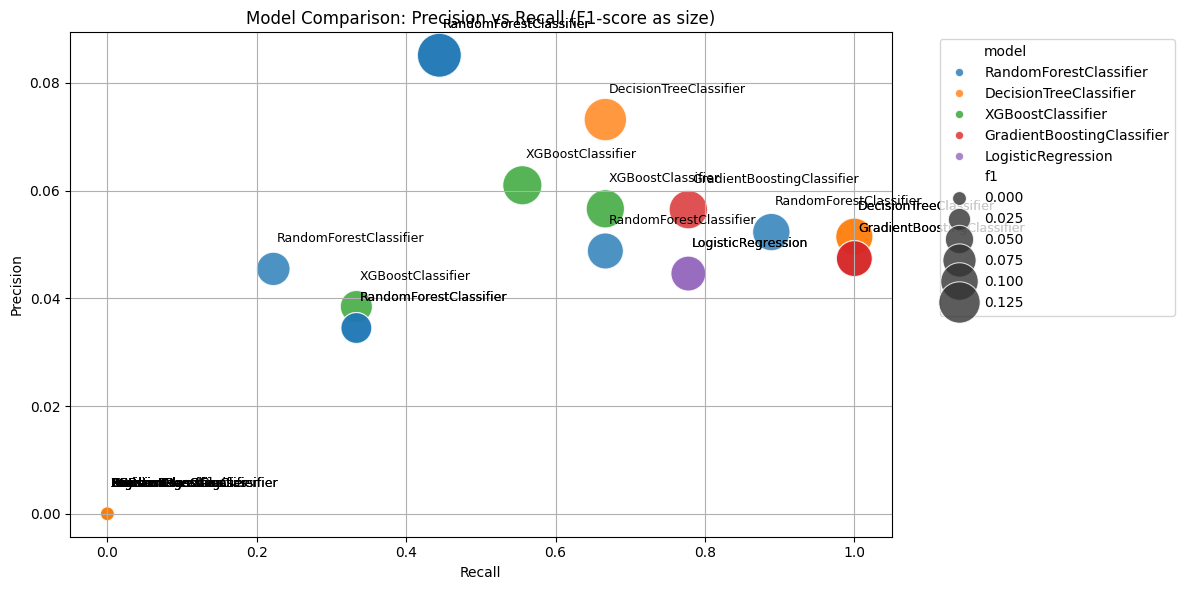

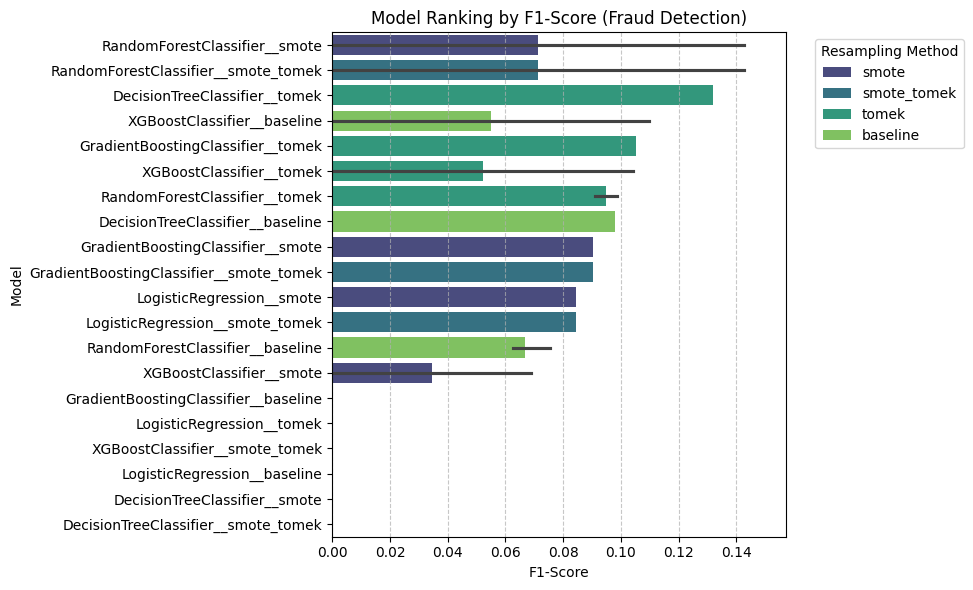

In [84]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# --------------------------
# Load CSV
# --------------------------
summary_path = r"D:\fraud_detection\notebook\no_optuna_all_model_summary_smote,tomek,smote+tomek.csv"
df = pd.read_csv(summary_path)

# --------------------------
# Rank models by F1-score
# --------------------------
df_ranked = df.sort_values(by='f1', ascending=False).reset_index(drop=True)
print("📊 Models ranked by F1-score:")
display(df_ranked[['model_id','model','method','f1','recall','precision']])

# --------------------------
# Scatter plot: Precision vs Recall with F1 as size
# --------------------------
plt.figure(figsize=(12,6))
sns.scatterplot(
    data=df_ranked, 
    x='recall', 
    y='precision', 
    size='f1', 
    hue='model', 
    alpha=0.8, 
    sizes=(100, 1000)
)

# Annotate models
for i, row in df_ranked.iterrows():
    plt.text(row['recall']+0.005, row['precision']+0.005, row['model'], fontsize=9)

plt.title("Model Comparison: Precision vs Recall (F1-score as size)")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

# --------------------------
# Horizontal bar plot of F1-scores
# --------------------------
plt.figure(figsize=(10, 6))
sns.barplot(
    data=df_ranked,
    y='model_id',      # horizontal bars
    x='f1',
    hue='method',
    dodge=False,
    palette='viridis'
)

plt.xlabel("F1-Score")
plt.ylabel("Model")
plt.title("Model Ranking by F1-Score (Fraud Detection)")
plt.xlim(0, df_ranked['f1'].max() * 1.1)
plt.legend(title='Resampling Method', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [64]:
# --------------------------
# Save best pipeline + threshold
# --------------------------
if not summary_df.empty:
    best_row = summary_df.iloc[0]
    best_id = best_row["model_id"]
    best_info = pipeline_store[best_id]
    best_pipeline_obj = best_info["pipeline"]
    best_threshold = best_info["threshold"]

    best_model_path = os.path.join(output_dir, "best_pipeline_no_optuna.pkl")
    joblib.dump(best_pipeline_obj, best_model_path)

    # also save scaler separately if exists in pipeline
    scaler_path = os.path.join(output_dir, "scaler_no_optuna.pkl")
    try:
        if "scaler" in best_pipeline_obj.named_steps:
            joblib.dump(best_pipeline_obj.named_steps["scaler"], scaler_path)
            print(f"📊 Scaler saved → {scaler_path}")
    except Exception as e:
        logging.warning(f"Could not save scaler separately: {e}")

    # save threshold
    threshold_path = os.path.join(output_dir, "best_threshold.txt")
    with open(threshold_path, "w") as f:
        f.write(str(best_threshold))

    print(f"🏆 Best pipeline saved: {best_id} → {best_model_path}")
    print(f"🔑 Best threshold saved → {threshold_path}")

# --------------------------
# Final sanity assertion: test distribution unchanged
# --------------------------
if not original_test_counts.equals(y_test.value_counts()):
    raise AssertionError("Test distribution changed during experiments! (It must remain untouched.)")
else:
    print("✅ Test distribution unchanged (sanity check passed).")

📊 Scaler saved → D:\fraud_detection\notebook\scaler_no_optuna.pkl
🏆 Best pipeline saved: DecisionTreeClassifier__tomek → D:\fraud_detection\notebook\best_pipeline_no_optuna.pkl
🔑 Best threshold saved → D:\fraud_detection\notebook\best_threshold.txt
✅ Test distribution unchanged (sanity check passed).


using optuna as hyperparameter tunning 

In [65]:
import requests

def setup_mlflow(tracking_uri_env: str, local_uri_env: str, experiment_name: str, timeout: int = 3):
    """Setup MLflow tracking URI and experiment with remote fallback."""
    def check_mlflow_server(uri: str) -> bool:
        try:
            resp = requests.get(f"{uri.rstrip('/')}/api/2.0/mlflow/experiments/list", timeout=timeout)
            return resp.status_code == 200
        except Exception:
            return False

    tracking_uri_env = (tracking_uri_env or "").strip()
    local_uri_env = (local_uri_env or "").strip()

    if tracking_uri_env and check_mlflow_server(tracking_uri_env):
        tracking_uri = tracking_uri_env
        logging.info(f"✅ Connected to MLflow server at {tracking_uri_env}")
    elif local_uri_env:
        tracking_uri = local_uri_env
        logging.warning(f"⚠️ Could not connect to {tracking_uri_env}. Falling back to {local_uri_env}")
    else:
        raise RuntimeError("❌ No valid MLflow tracking URI found.")

    if tracking_uri.startswith("file:///"):
        local_path = tracking_uri.replace("file:///", "")
        pathlib.Path(local_path).mkdir(parents=True, exist_ok=True)

    mlflow.set_tracking_uri(tracking_uri)
    exp = mlflow.set_experiment(experiment_name)

    logging.info(f"MLflow tracking URI = {tracking_uri}, experiment = {experiment_name}")
    return tracking_uri, exp.experiment_id

In [70]:
# ensure test distribution kept as-is
original_test_counts = y_test.value_counts().copy()
logging.info(f"Original test distribution:\n{original_test_counts}")

2025-09-20 18:56:02,301 - INFO - Original test distribution:
FraudIndicator
0    191
1      9
Name: count, dtype: int64


In [69]:
import os
from dotenv import load_dotenv

load_dotenv()  # loads the .env file content into environment variables



# -------------------------
# Setup MLflow (from .env)
# -------------------------
tracking_uri, exp_id = setup_mlflow(
    tracking_uri_env=os.getenv("MLFLOW_TRACKING_URI"),
    local_uri_env=os.getenv("MLFLOW_LOCAL_URI"),
    experiment_name=os.getenv("MLFLOW_EXPERIMENT_NAME_3")
)

2025-09-20 18:55:29,752 - WARNING - ⚠️ Could not connect to http://127.0.0.1:5000. Falling back to file:///D:/fraud_detection/mlruns
2025/09/20 18:55:29 INFO mlflow.tracking.fluent: Experiment with name 'fraud_detection_experiment_3' does not exist. Creating a new experiment.
2025-09-20 18:55:29,790 - INFO - MLflow tracking URI = file:///D:/fraud_detection/mlruns, experiment = fraud_detection_experiment_3


In [72]:
import optuna
from optuna.samplers import TPESampler
from sklearn.model_selection import StratifiedKFold, cross_val_score

In [75]:
# -------------------------
# Optuna Objective Functions
# -------------------------
def objective_xgb(trial, X_train, y_train, X_val, y_val, sampler=None):
    """Optimize XGBoost for F1 (minority class) with early stopping"""
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),
        'reg_lambda': trial.suggest_float('reg_lambda', 1, 10),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10)
    }

    # Scale and optionally resample
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)

    if sampler is not None:
        X_train_resampled, y_train_resampled = sampler.fit_resample(X_train_scaled, y_train)
    else:
        X_train_resampled, y_train_resampled = X_train_scaled, y_train

    # Train with early stopping
    model = xgb.XGBClassifier(
        random_state=RANDOM_STATE,
        eval_metric="logloss",
        scale_pos_weight=pos_weight,
        n_estimators=1000,
        early_stopping_rounds=20,
        n_jobs=-1,
        **params
    )

    model.fit(
        X_train_resampled, y_train_resampled,
        eval_set=[(X_val_scaled, y_val)],
        verbose=False
    )

    y_pred = model.predict(X_val_scaled)
    return f1_score(y_val, y_pred, zero_division=0)

In [76]:
def objective_rf(trial, X_train, y_train, X_val, y_val, sampler=None):
    """Optimize RandomForest for F1 (minority class)"""
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None])
    }

    if sampler is not None:
        scaler = MinMaxScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_train_resampled, y_train_resampled = sampler.fit_resample(X_train_scaled, y_train)
    else:
        X_train_resampled, y_train_resampled = X_train, y_train

    model = RandomForestClassifier(
        random_state=RANDOM_STATE,
        class_weight='balanced',
        n_jobs=-1,
        **params
    )

    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)
    scores = cross_val_score(model, X_train_resampled, y_train_resampled, cv=cv, scoring='f1', n_jobs=-1)
    return scores.mean()



In [ ]:
# -------------------------
# Experiment loop with Optuna
# -------------------------
for method_name, sampler in resampling_methods.items():
    logging.info(f"=== RESAMPLING: {method_name} ===")

    for model_name, model_obj in models.items():
        model_id = f"{model_name}__{method_name}"
        logging.info(f"Running {model_id} with Optuna optimization")

        with mlflow.start_run(run_name=model_id, experiment_id=exp_id):

            if model_name == "XGBoostClassifier":
                study = optuna.create_study(direction='maximize', sampler=TPESampler(seed=RANDOM_STATE))
                study.optimize(lambda trial: objective_xgb(trial, X_train, y_train, X_val, y_val, sampler), n_trials=30)

                best_params = study.best_params
                best_score = study.best_value

                # Train final XGBoost with best params
                scaler = MinMaxScaler()
                X_train_scaled = scaler.fit_transform(X_train)
                X_val_scaled = scaler.transform(X_val)
                X_test_scaled = scaler.transform(X_test)

                if sampler is not None:
                    X_train_resampled, y_train_resampled = sampler.fit_resample(X_train_scaled, y_train)
                else:
                    X_train_resampled, y_train_resampled = X_train_scaled, y_train

                final_model = xgb.XGBClassifier(
                    random_state=RANDOM_STATE,
                    eval_metric="logloss",
                    scale_pos_weight=pos_weight,
                    n_estimators=1000,
                    early_stopping_rounds=20,
                    n_jobs=-1,
                    **best_params
                )

                final_model.fit(
                    X_train_resampled, y_train_resampled,
                    eval_set=[(X_val_scaled, y_val)],
                    verbose=False
                )

                optimal_model = xgb.XGBClassifier(
                    random_state=RANDOM_STATE,
                    eval_metric="logloss",
                    scale_pos_weight=pos_weight,
                    n_estimators=final_model.best_iteration,
                    **best_params
                )
                optimal_model.fit(X_train_resampled, y_train_resampled)

                best_pipeline = {'scaler': scaler, 'sampler': sampler, 'model': optimal_model}

                y_val_proba = optimal_model.predict_proba(X_val_scaled)[:, 1]
                y_test_proba = optimal_model.predict_proba(X_test_scaled)[:, 1]

                mlflow.log_params(best_params)
                mlflow.log_metric("optuna_best_score", best_score)
                mlflow.log_param("best_iteration", final_model.best_iteration)

            elif model_name == "RandomForestClassifier":
                study = optuna.create_study(direction='maximize', sampler=TPESampler(seed=RANDOM_STATE))
                study.optimize(lambda trial: objective_rf(trial, X_train, y_train, X_val, y_val, sampler), n_trials=20)

                best_params = study.best_params
                best_score = study.best_value

                # Train final RandomForest
                if sampler is not None:
                    scaler = MinMaxScaler()
                    X_train_scaled = scaler.fit_transform(X_train)
                    X_train_resampled, y_train_resampled = sampler.fit_resample(X_train_scaled, y_train)
                else:
                    X_train_resampled, y_train_resampled = X_train, y_train

                final_model = RandomForestClassifier(
                    random_state=RANDOM_STATE,
                    class_weight='balanced',
                    n_jobs=-1,
                    **best_params
                )
                final_model.fit(X_train_resampled, y_train_resampled)
                best_pipeline = {'scaler': scaler if sampler else None, 'sampler': sampler, 'model': final_model}

                y_val_proba = final_model.predict_proba(X_val)[:, 1]
                y_test_proba = final_model.predict_proba(X_test)[:, 1]

                mlflow.log_params(best_params)
                mlflow.log_metric("optuna_best_score", best_score)

            else:
                # For other models, retain your current pipeline approach
                continue  # Placeholder: keep your existing pipeline code

            # -------------------------
            # Threshold tuning and final evaluation 
            # -------------------------
            precision_vec, recall_vec, thresholds = precision_recall_curve(y_val, y_val_proba)
            if thresholds.size > 0:
                f1_for_thresholds = 2 * (precision_vec[:-1] * recall_vec[:-1]) / (precision_vec[:-1] + recall_vec[:-1] + 1e-12)
                best_idx = int(np.nanargmax(f1_for_thresholds))
                best_threshold = float(thresholds[best_idx])
            else:
                best_threshold = 0.5

            mlflow.log_metric("best_threshold", best_threshold)
            y_test_pred = (y_test_proba >= best_threshold).astype(int)

            acc = accuracy_score(y_test, y_test_pred)
            prec = precision_score(y_test, y_test_pred, zero_division=0)
            rec = recall_score(y_test, y_test_pred, zero_division=0)
            f1_val = f1_score(y_test, y_test_pred, zero_division=0)
            roc = roc_auc_score(y_test, y_test_proba) if len(np.unique(y_test)) > 1 else float('nan')
            p_vec, r_vec, _ = precision_recall_curve(y_test, y_test_proba)
            pr_auc = auc(r_vec, p_vec)
            cm = confusion_matrix(y_test, y_test_pred)

            mlflow.log_metrics({
                "accuracy": acc,
                "precision": prec,
                "recall": rec,
                "f1": f1_val,
                "roc_auc": roc,
                "pr_auc": pr_auc
            })

            # Store results
            all_results.append({
                "model_id": model_id,
                "model": model_name,
                "method": method_name,
                "accuracy": acc,
                "precision": prec,
                "recall": rec,
                "f1": f1_val,
                "roc_auc": roc,
                "pr_auc": pr_auc,
                "threshold": best_threshold,
                "confusion_matrix": cm
            })
            pipeline_store[model_id] = {"pipeline": best_pipeline, "threshold": best_threshold, "metrics": all_results[-1]}


2025-09-20 19:03:15,889 - INFO - === RESAMPLING: baseline ===
2025-09-20 19:03:15,889 - INFO - Running LogisticRegression__baseline with Optuna optimization
2025-09-20 19:03:15,965 - INFO - Running DecisionTreeClassifier__baseline with Optuna optimization
2025-09-20 19:03:16,021 - INFO - Running RandomForestClassifier__baseline with Optuna optimization
[I 2025-09-20 19:03:16,077] A new study created in memory with name: no-name-fa9ca967-2b53-407f-b56b-fd8d3a5c0490
[I 2025-09-20 19:03:21,394] Trial 0 finished with value: 0.0 and parameters: {'n_estimators': 144, 'max_depth': 20, 'min_samples_split': 15, 'min_samples_leaf': 6, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.0.
[I 2025-09-20 19:03:24,040] Trial 1 finished with value: 0.0 and parameters: {'n_estimators': 267, 'max_depth': 13, 'min_samples_split': 15, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.0.
[I 2025-09-20 19:03:26,037] Trial 2 finished with value: 0.0 and parameters: {'n_estima

In [78]:
# --------------------------
# Summarize and save CSV
# --------------------------
summary_df = pd.DataFrame(all_results).sort_values(by=["f1", "pr_auc"], ascending=False).reset_index(drop=True)
display(summary_df)

output_dir = r"D:\fraud_detection\notebook"
os.makedirs(output_dir, exist_ok=True)
summary_path = os.path.join(output_dir, "optuna_hyper_model_summary_smote,tomek,smote+tomek.csv")
summary_df.to_csv(summary_path, index=False)
print(f"📊 Combined model summary saved at: {summary_path}")

,model_id,model,method,accuracy,precision,recall,f1,roc_auc,pr_auc,threshold,confusion_matrix
0,RandomForestClassifier__smote,RandomForestClassifier,smote,0.760,0.085106,0.444444,0.142857,0.689354,0.077139,0.138462,"[[148, 43], [5, 4]]"
1,RandomForestClassifier__smote_tomek,RandomForestClassifier,smote_tomek,0.760,0.085106,0.444444,0.142857,0.689354,0.077139,0.138462,"[[148, 43], [5, 4]]"
2,DecisionTreeClassifier__tomek,DecisionTreeClassifier,tomek,0.605,0.073171,0.666667,0.131868,0.626527,0.051943,0.556937,"[[115, 76], [3, 6]]"
3,XGBoostClassifier__baseline,XGBoostClassifier,baseline,0.595,0.060976,0.555556,0.109890,0.541012,0.045819,0.055010,"[[114, 77], [4, 5]]"
4,GradientBoostingClassifier__tomek,GradientBoostingClassifier,tomek,0.405,0.056452,0.777778,0.105263,0.625945,0.080759,0.013617,"[[74, 117], [2, 7]]"
5,XGBoostClassifier__tomek,XGBoostClassifier,tomek,0.485,0.056604,0.666667,0.104348,0.547411,0.045376,0.017369,"[[91, 100], [3, 6]]"
6,RandomForestClassifier__tomek,RandomForestClassifier,tomek,0.270,0.052288,0.888889,0.098765,0.546830,0.045553,0.153237,"[[46, 145], [1, 8]]"
7,DecisionTreeClassifier__baseline,DecisionTreeClassifier,baseline,0.170,0.051429,1.000000,0.097826,0.591332,0.030829,0.197927,"[[25, 166], [0, 9]]"
8,DecisionTreeClassifier__baseline,DecisionTreeClassifier,baseline,0.170,0.051429,1.000000,0.097826,0.591332,0.030829,0.197927,"[[25, 166], [0, 9]]"
9,RandomForestClassifier__tomek,RandomForestClassifier,tomek,0.400,0.048780,0.666667,0.090909,0.534322,0.045798,0.053711,"[[74, 117], [3, 6]]"


📊 Combined model summary saved at: D:\fraud_detection\notebook\optuna_hyper_model_summary_smote,tomek,smote+tomek.csv


In [79]:
# --------------------------
# Save best pipeline + threshold
# --------------------------
if not summary_df.empty:
    best_row = summary_df.iloc[0]
    best_id = best_row["model_id"]
    best_info = pipeline_store[best_id]
    best_pipeline_obj = best_info["pipeline"]
    best_threshold = best_info["threshold"]

    best_model_path = os.path.join(output_dir, "best_pipeline_optuna.pkl")
    joblib.dump(best_pipeline_obj, best_model_path)

    # also save scaler separately if exists in pipeline
    scaler_path = os.path.join(output_dir, "scaler_optuna.pkl")
    try:
        if "scaler" in best_pipeline_obj.named_steps:
            joblib.dump(best_pipeline_obj.named_steps["scaler"], scaler_path)
            print(f"📊 Scaler saved → {scaler_path}")
    except Exception as e:
        logging.warning(f"Could not save scaler separately: {e}")

    # save threshold
    threshold_path = os.path.join(output_dir, "best_threshold.txt")
    with open(threshold_path, "w") as f:
        f.write(str(best_threshold))

    print(f"🏆 Best pipeline saved: {best_id} → {best_model_path}")
    print(f"🔑 Best threshold saved → {threshold_path}")

# --------------------------
# Final sanity assertion: test distribution unchanged
# --------------------------
if not original_test_counts.equals(y_test.value_counts()):
    raise AssertionError("Test distribution changed during experiments! (It must remain untouched.)")
else:
    print("✅ Test distribution unchanged (sanity check passed).")

2025-09-20 19:14:05,192 - WARNING - Could not save scaler separately: 'dict' object has no attribute 'named_steps'


🏆 Best pipeline saved: RandomForestClassifier__smote → D:\fraud_detection\notebook\best_pipeline_optuna.pkl
🔑 Best threshold saved → D:\fraud_detection\notebook\best_threshold.txt
✅ Test distribution unchanged (sanity check passed).


📊 Models ranked by F2-score:


,model_id,model,method,f2_score,recall,precision
0,DecisionTreeClassifier__tomek,DecisionTreeClassifier,tomek,0.254237,0.666667,0.073171
1,RandomForestClassifier__smote,RandomForestClassifier,smote,0.240964,0.444444,0.085106
2,RandomForestClassifier__smote_tomek,RandomForestClassifier,smote_tomek,0.240964,0.444444,0.085106
3,GradientBoostingClassifier__tomek,GradientBoostingClassifier,tomek,0.218750,0.777778,0.056452
4,DecisionTreeClassifier__baseline,DecisionTreeClassifier,baseline,0.213270,1.000000,0.051429
5,DecisionTreeClassifier__baseline,DecisionTreeClassifier,baseline,0.213270,1.000000,0.051429
6,XGBoostClassifier__baseline,XGBoostClassifier,baseline,0.211864,0.555556,0.060976
7,RandomForestClassifier__tomek,RandomForestClassifier,tomek,0.211640,0.888889,0.052288
8,XGBoostClassifier__tomek,XGBoostClassifier,tomek,0.211268,0.666667,0.056604
9,GradientBoostingClassifier__smote_tomek,GradientBoostingClassifier,smote_tomek,0.199115,1.000000,0.047368


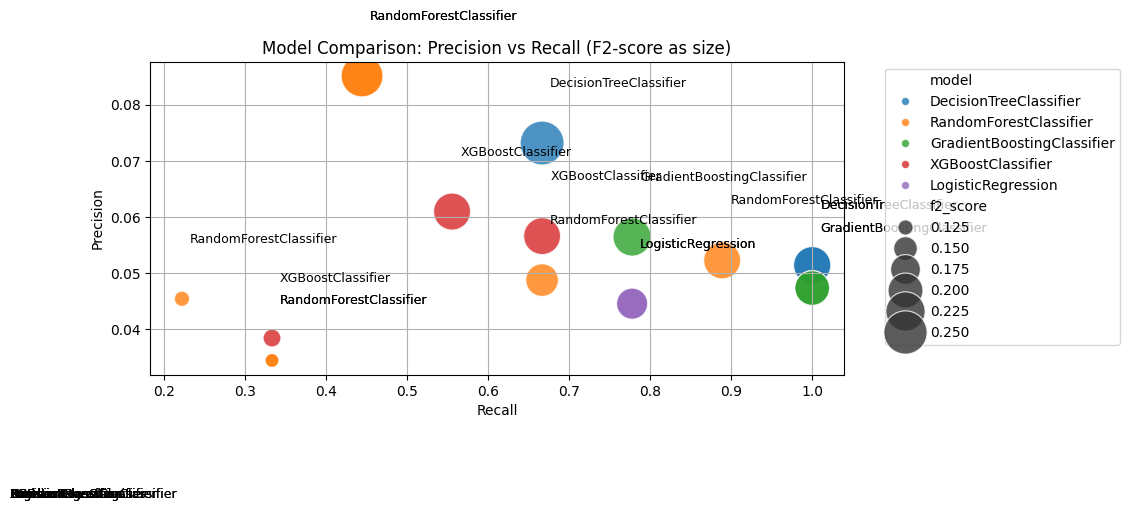

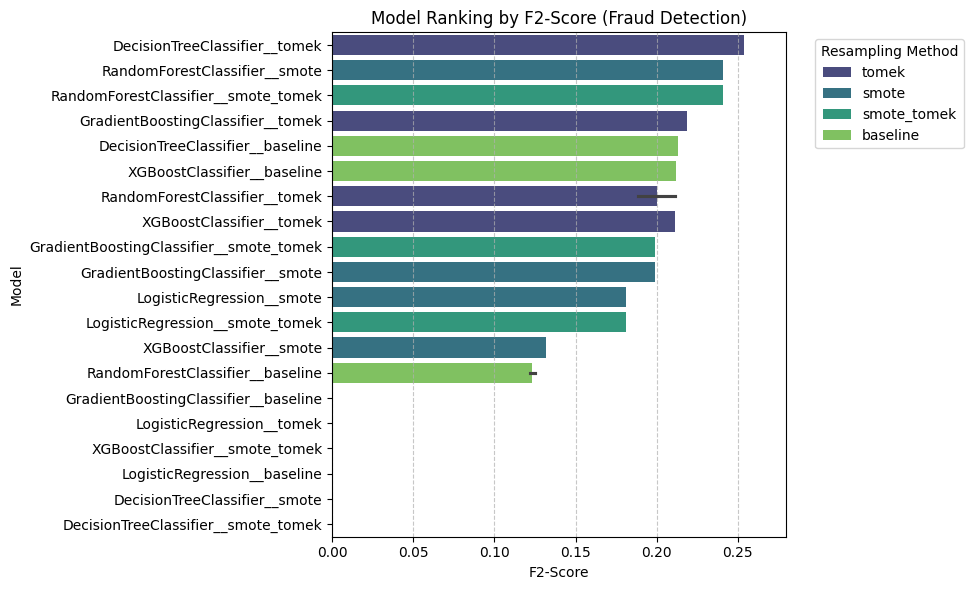

In [81]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# --------------------------
# Load CSV
# --------------------------
summary_path = r"D:\fraud_detection\notebook\optuna_hyper_model_summary_smote,tomek,smote+tomek.csv"
df = pd.read_csv(summary_path)

# --------------------------
# Compute F2-score
# F2 = (1 + 2^2) * (precision * recall) / ((2^2 * precision) + recall)
# --------------------------
beta = 2
df['f2_score'] = (1 + beta**2) * (df['precision'] * df['recall']) / ((beta**2 * df['precision']) + df['recall'])

# --------------------------
# Rank models by F2
# --------------------------
df_ranked = df.sort_values(by='f2_score', ascending=False).reset_index(drop=True)
print("📊 Models ranked by F2-score:")
display(df_ranked[['model_id','model','method','f2_score','recall','precision']])

# --------------------------
# Visualize F2 vs Recall vs Precision
# --------------------------
plt.figure(figsize=(12,6))
sns.scatterplot(data=df_ranked, x='recall', y='precision', size='f2_score', hue='model', alpha=0.8, sizes=(100, 1000))
for i, row in df_ranked.iterrows():
    plt.text(row['recall']+0.01, row['precision']+0.01, row['model'], fontsize=9)

plt.title("Model Comparison: Precision vs Recall (F2-score as size)")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


# --------------------------
# Horizontal bar plot of F2-scores
# --------------------------
plt.figure(figsize=(10, 6))
sns.barplot(
    data=df_ranked,
    y='model_id',      # horizontal bars
    x='f2_score',
    hue='method',
    dodge=False,
    palette='viridis'
)

plt.xlabel("F2-Score")
plt.ylabel("Model")
plt.title("Model Ranking by F2-Score (Fraud Detection)")
plt.xlim(0, df_ranked['f2_score'].max() * 1.1)
plt.legend(title='Resampling Method', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
